# A neural network

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
def sigmoid(x) : 
    return 1/(1+np.exp(-x))

def dsigmoid(x) :
    return sigmoid(x)*(1-sigmoid(x))

def relu(x) :
    return np.maximum(x,0)

def drelu(x) :
    #return (x > 0)*1
    return np.heaviside(x,0.5)
    
class NN_layer : 
    
    def __init__(self, input_size, output_size, activation_function) : 
        self.activation = activation_function
        self.weights = np.random.uniform(-0.7, 0.7, (input_size, output_size)) 
        self.bias = 0.01*np.random.rand(1, output_size)
    
    # inputs should be a row vector
    # or a matrix with each row having the right dimension 
    def activate(self, inputs) :
        z = (inputs @ self.weights) + self.bias
        a = self.activation(z)
        return a, z

class my_NN :
    
    activation_functions = {
        'sigmoid' : (sigmoid, dsigmoid),
        'linear' : (lambda x : x, lambda x : 1),
        'relu' : (relu, drelu)
    }
    
    # my cost functions really only work when there is a single output
    # so both pred and true below are column vectors 
    # and the output should be a column vector as well
    # For the cross entropy we need to test if pred is zero or 1, since if it is the formula divides by zero'
    # so in that case we simply return 0 (i.e no futher changes needed)
    cost_functions_diff = {
        'square error' : ( lambda pred, target : (pred-target)),
        'cross entropy' : ( lambda pred, target : (pred - target)/(pred*(1-pred)) if  ((not pred.any()) or not (pred-1).any()) else 0 )
    }
    #'cross entropy' : ( lambda pred, true : (sigmoid(pred) - true) * pred)    
        
    def __init__(self, layer_sizes, hidden_activation, out_activation) :
        self.hact, self.dhact = self.activation_functions[hidden_activation]
        self.outact, self.doutact = self.activation_functions[out_activation]
        self.number_of_layers = len(layer_sizes)-1
        # add the hidden layers
        self.layers = [NN_layer(layer_sizes[k], layer_sizes[k+1], self.hact) for k in range(0, self.number_of_layers-1)]
        # add the final layer
        self.layers.append(NN_layer(layer_sizes[self.number_of_layers-1], layer_sizes[self.number_of_layers], self.outact))
    
    def feed_forward(self, inputs) :
        acts = [inputs]
        zs = [np.zeros(inputs.shape)] # just put something in the zeros entry of zs, for indexing purposes
        for l in range(0, self.number_of_layers) :
            a,z = self.layers[l].activate(acts[l])
            acts.append(a)
            zs.append(z)
               
        return acts, zs 

    def predict(self, inputs) :
        acts, zs = self.feed_forward(inputs)
        return acts[-1]

    
    def one_step_back_propagate(self, batch, learning_rate, dsummand) :
        batch_size = batch.shape[0] # number of rows in batch
        deltas = [] # list of deltas, build starting from the back
        
        # first feed forward to compute as and zs
        acts, zs = self.feed_forward(batch)

        # Compute deltas, according to formulas from Nielsen's boook
        # http://neuralnetworksanddeeplearning.com/chap2.html
        # Since each delta only depends on the previously computed delta, 
        # we use pythons -1 indexing
        
        # First we define the final delta 
        deltas.append(dsummand(acts[-1])*self.doutact(zs[self.number_of_layers]))
        deltas[-1].reshape(1,-1)
        # then each is defines using the previously computed 
        for layer, z in zip(self.layers[-1::-1], zs[-2:0:-1]) :
            deltas.append((deltas[-1] @ layer.weights.T)*self.dhact(z))
                        
        # Now update the weights and biases
        # We go through the layers and activations from behind, 
        # we do not consider the final activation, as that does not appear in the formulas 
        # We use of np.mean for the bias update but not for the weights, 
        # due to the way matrix multiplication works, (1/batch_size) * (a.T @ delta)
        # is the average row_of_a.T @ row_of_delta (as they run over all row).
        # For the biases we need forcefully take the avarage
        for layer, a, delta in zip(self.layers[::-1], acts[-2::-1], deltas):
            layer.weights = layer.weights - (learning_rate/batch_size) * (a.T @ delta)
            layer.bias = layer.bias - learning_rate * np.mean(delta, axis=0)
            
            
    def train(self, X, Y, cost_function = 'square error', learning_rate = 0.01, epochs = 100, batch_size = 1, verbose = False) :
        N = Y.shape[0] # number of rows in Y, i.e. number of data points
        m = int(N/batch_size) # number of batches
        dsummand = self.cost_functions_diff[cost_function]
        
        # For verbose printing 
        tenpct = epochs // 10
        count = 0
        
        for epo in range(epochs) : 
            if verbose:
                count += 1
                if count == tenpct :
                    print("Working on epoch %d" % epo)
                    count = 0
            #print("The MSE before this epoch is %f" % mean_squared_error(self.predict(X), Y))
            batches = np.random.permutation(N).reshape((-1, m))
            for b in batches :
                X_batch = X[b]
                Y_batch = Y[b].reshape(-1,1) # make Y_batch a column vector
                dout = (lambda a : dsummand(a,Y_batch))
                self.one_step_back_propagate(X_batch, learning_rate, dout)

## Comparing our backpropagation algorithm to sci-kit learn

Following the ideas of the note in piazza (https://piazza.com/class/ji78s1cduul39a?cid=107), we will compare our back propagation to that from sci-kit learn.
We set up a MLPRegressor from scikit learn, make it do one back propergation step, and then compare the weights after we have trained our network. 

In [3]:
import warnings
from sklearn.neural_network import MLPRegressor

X = np.array([[0.0], [1.0]])
y = np.array([0, 2])
mlp = MLPRegressor( solver              = 'sgd',      # Stochastic gradient descent.
                    activation          = 'logistic', # Skl name for sigmoid.
                    alpha               = 0.0,        # No regularization for simplicity.
                    momentum            = 0.0,        # Similarly no momentum to the sgd
                    max_iter            = 1,          # Only do one step per fit call
                    hidden_layer_sizes  = (3, 3))     # Full network is of size (1,3,3,1),

# Force sklearn to set up all the necessary matrices by fitting a data set. 
# We dont care if it converges or not, so lets ignore raised warnings.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mlp.fit(X,y)

# We now make my network, and give it the same weights and biases
nn = my_NN([1,3,3,1], 'sigmoid', 'linear')

# Copy the weights and biases from the scikit-learn network to your own.
# keep them for record keeping, so we can compute weight changes
old_weights = []
old_biases = []
for i, w in enumerate(mlp.coefs_) :
    nn.layers[i].weights = np.copy(w)
    old_weights.append(np.copy(w))
for i, b in enumerate(mlp.intercepts_) :
    nn.layers[i].bias = np.copy(b)
    old_biases.append(np.copy(b))

# pick a point and check that the two networks give the same values
    
X      = np.array([[1.0]])
target = np.array([[2.0]])    

print("We the weights initialized to the same thing, the two networks make same predictions")
print("My network predicts")
print(nn.predict(X))
print("The mlp regressor predicts")
print(mlp.predict(X))
print("")

########
# We take on backpropagation step in my network, by simply training with a single epoch. 
my_activations, my_zs = nn.feed_forward(X)
nn.train(X, target,  learning_rate = 1, epochs = 1, batch_size = 1)
new_weights = [nn.layers[i].weights for i in range(0,3) ]
new_biases = [nn.layers[i].bias for i in range(0,3)]
# Now we can recover the gradients of the weights by looking at the weight differences 
my_coef_grads = [(ow - nw) for (ow,nw) in zip(old_weights, new_weights)]
my_bias_grads = [(ob - nb) for (ob, nb) in zip(old_biases, new_biases) ]

# All this is setup to call the _forward_pass and _backprop methods    
# ==========================================================================
n_samples, n_features   = X.shape
batch_size              = n_samples
hidden_layer_sizes      = mlp.hidden_layer_sizes
if not hasattr(hidden_layer_sizes, "__iter__"):
    hidden_layer_sizes = [hidden_layer_sizes]
hidden_layer_sizes = list(hidden_layer_sizes)
layer_units = ([n_features] + hidden_layer_sizes + [mlp.n_outputs_])
activations = [X]
activations.extend(np.empty((batch_size, n_fan_out)) 
                   for n_fan_out in layer_units[1:])
deltas      = [np.empty_like(a_layer) for a_layer in activations]
coef_grads  = [np.empty((n_fan_in_, n_fan_out_)) 
               for n_fan_in_, n_fan_out_ in zip(layer_units[:-1],
                                                layer_units[1:])]
intercept_grads = [np.empty(n_fan_out_) for n_fan_out_ in layer_units[1:]]
# ==========================================================================
    
activations                       = mlp._forward_pass(activations) 
loss, coef_grads, intercept_grads = mlp._backprop(X, target, activations, deltas, coef_grads, intercept_grads)

print("We first compare the activations, if they are equal we print of list of trues")
print([np.allclose(mya, a) for (mya, a) in zip(my_activations, activations)])
print("")

print("We then compare teh coeficient grads from mlp an my network.")
print("For each layer we ask Sci-kit learn if the coefs are equal, if they are we print a list of trues")
print([np.allclose(my_grad, mlp_grad) for (my_grad, mlp_grad) in zip(my_coef_grads, coef_grads)])
print("Same deal for biases")
print([np.allclose(my_grad, mlp_grad) for (my_grad, mlp_grad) in zip(my_coef_grads, coef_grads)])
print("")


# Now train my network and deduce the deltas
#nn.train(X, target, cost_function = 'square error', learning_rate = 0.001, epochs = 1, batch_size = 1, verbose = False)

#for i, layer in enumerate(nn.layers) :
    #print(mlp.coefs_[i] - old_weights[i])
    #assert(np.allclose(mlp.coefs_[i], old_weights[i]))
    #print(layer.weights - mlp.coefs_[i])
    #assert(np.allclose(layer.weights, mlp.coefs_[i]))
    #print(layer.bias - mlp.intercepts_[i])
    #assert(np.allclose(layer.bias, mlp.intercepts_[i]))


We the weights initialized to the same thing, the two networks make same predictions
My network predicts
[[0.38626509]]
The mlp regressor predicts
[0.38626509]

We first compare the activations, if they are equal we print of list of trues
[True, True, True, True]

We then compare teh coeficient grads from mlp an my network.
For each layer we ask Sci-kit learn if the coefs are equal, if they are we print a list of trues
[True, True, True]
Same deal for biases
[True, True, True]



## A simple test of the mean square version of the network

We try to predict a 3rd degree polynomial

Network build and trained


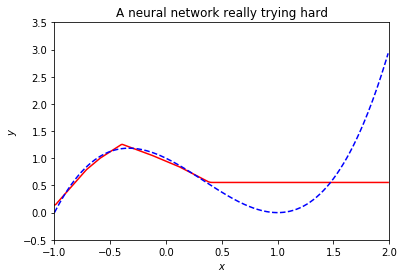

The MSE is 0.409296


In [4]:
#### setup som basic data
#### first the function we are trying to approximate
def p3(x) :
    return (x+1.0)*(x-1.0)*(x-1.0)

#### xs will be a list of random numbers between -1 and 2
xs = 3*np.random.rand(1000,1) - 1 
#### ys are the p3 values of the xs
ys = p3(xs)
# Split our data into training and testing. 
# 20% (0.2) saved to test aginst
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size = 0.2)

net = my_NN([1,3,5,7,1], 'relu', 'linear')
#net = my_NN([1,2,1], 'relu', 'linear')
net.train(x_train, y_train, cost_function = 'square error', learning_rate = 0.01, epochs = 300, batch_size = 80)
print("Network build and trained")

# generate a bunch of x's for plotting
xstep = 0.01
xpoints = np.arange(-1.0, 2.0, xstep)

# Compute the predicted y values for all the plotting x's
ypredict = net.predict(xpoints.reshape(-1,1))
#print(ypredict.shape)
#print(ypredict)
# Do the plotting
# first draw a line between the plotting x's and their predicted y's 
plt.plot(xpoints, ypredict, "r-")
# Then plot the points we predicted from
plt.plot(xpoints, p3(xpoints) ,'b--')
# Setup axis and labels
plt.axis([-1.0, 2.0, -0.5, 3.5])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'A neural network really trying hard')
plt.show()
print("The MSE is %f" % mean_squared_error(net.predict(x_test), y_test))



## Testing the corss entropy version of the network

We are using the moons data set from sci-kit learn

How the logistic regression from sci-kit learn behaves


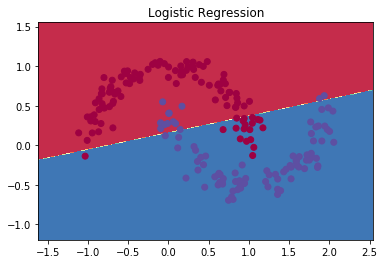

Accuracy: 0.845000

Now building neural network to try to solve the problem
Network build and trained


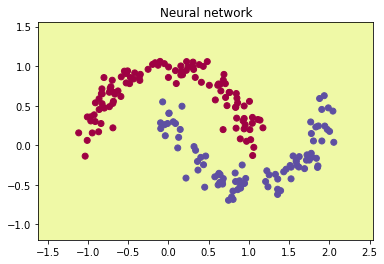

Accuracy: 0.450000


In [5]:
def generate_data():
    np.random.seed(0)
    X, y = datasets.make_moons(1000, noise=0.1)
    return X, y

def visualize(X, y, clf):
    # plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
    # plt.show()
    plot_decision_boundary( lambda x: clf.predict(x), X, y)

def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.title("Logistic Regression")
    plt.show()
    
def classify(X, y):
    clf = linear_model.LogisticRegressionCV()
    clf.fit(X, y)
    return clf

X, y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# visualize(X, y)
clf = classify(X_train, y_train)

print("How the logistic regression from sci-kit learn behaves")

visualize(X_test, y_test, clf)
print("Accuracy: %f" % accuracy_score(y_test, clf.predict(X_test)))

print("")
###############
# my stuff

print("Now building neural network to try to solve the problem")
net = my_NN([2,5,3,7,1], 'relu', 'sigmoid')
net.train(X_train, y_train, cost_function = 'cross entropy', learning_rate = 0.01, epochs = 500, batch_size = 80)
print("Network build and trained")

pdb = lambda x : np.around(net.predict(x))

# Set min and max values and give it some padding
x_min, x_max = X_test[:, 0].min() - .5, X_test[:, 0].max() + .5
y_min, y_max = X_test[:, 1].min() - .5, X_test[:, 1].max() + .5
h = 0.01
# Generate a grid of points with distance h between them
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Predict the function value for the whole gid
Z = pdb(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plot the contour and training examples
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Spectral)
plt.title("Neural network")
plt.show()

print("Accuracy: %f" % accuracy_score(y_test, pdb(X_test)))


## Ising model using neural net

In [6]:
########## 
# first we set up the Ising energy data

# System size and number of systems
L = 40
sysnum = 1000

# random Ising states
states = np.random.choice([-1.0,1.0], size=(sysnum, L))

def ising_energies(states,L):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    From the project description 
    """
    J=np.zeros((L,L),)
    for i in range(L):
        J[i,(i+1)%L]-=1.0
    
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)
    return E

# calculate Ising energies
energies=ising_energies(states,L)

states_train, states_test, E_train, E_test = train_test_split(states, energies, test_size=0.2)
print(states_train)




[[ 1. -1. -1. ...  1. -1. -1.]
 [ 1. -1. -1. ... -1.  1. -1.]
 [-1.  1. -1. ... -1. -1. -1.]
 ...
 [ 1.  1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1.  1.]
 [-1.  1. -1. ... -1. -1. -1.]]


In [7]:
net = my_NN([40, 80, 1], 'sigmoid', 'linear')
net.train(states_train, E_train, cost_function = 'square error', learning_rate = 0.1, epochs = 4000, batch_size = 100, verbose = True)
print("Network build and trained")

prediction = net.predict(states_test)
#print(prediction)
print("The MSE of the net is %f" % mean_squared_error(E_test, prediction))
print("The R2 score of the net is %f" % r2_score(E_test, prediction))


Working on epoch 399
Working on epoch 799
Working on epoch 1199
Working on epoch 1599
Working on epoch 1999
Working on epoch 2399
Working on epoch 2799
Working on epoch 3199
Working on epoch 3599
Working on epoch 3999
Network build and trained
The MSE of the net is 44.337304
The R2 score of the net is -0.011676


## What did we learn

We see that our Ising energi predictions are quite poor. It is known that Neural Networks can have a hard time emulating the logical xor function. Computing Ising energies, is basically a variation on that. Below we explore how out network can train to solve our variation of the problem. That is, can we have out network act as 

 N(1,1)      = 1
 N(1,-1)     = 0
 N(-1, 1)    = 0
 N(-1, -1)   = 1

With learning rate 1.000000 and running for 1000 epochs, we get and error of 0.198204
With learning rate 1.000000 and running for 5000 epochs, we get and error of 0.249975
With learning rate 1.000000 and running for 10000 epochs, we get and error of 0.250552
With learning rate 1.000000 and running for 15000 epochs, we get and error of 0.281039
With learning rate 0.100000 and running for 1000 epochs, we get and error of 0.000000
With learning rate 0.100000 and running for 5000 epochs, we get and error of 0.197526
With learning rate 0.100000 and running for 10000 epochs, we get and error of 0.249574
With learning rate 0.100000 and running for 15000 epochs, we get and error of 0.256298
With learning rate 0.010000 and running for 1000 epochs, we get and error of 0.000000
With learning rate 0.010000 and running for 5000 epochs, we get and error of 0.000000
With learning rate 0.010000 and running for 10000 epochs, we get and error of 0.249976
With learning rate 0.010000 and running for 15000

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


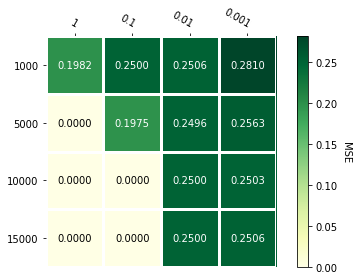

In [8]:
############## This is code to do neat plotting, taken from:
# https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
############################################################################
############################################################################
############################################################################
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

############################################################################
############################################################################
############################################################################
##### plotting code over

net = my_NN([2,2,1], 'sigmoid', 'linear')
X = np.array([[1,1],[1,-1],[-1,1],[-1,-1]])
Y = np.array([[1],[0],[0],[1]])

learning_rates = [1, 0.1, 0.01, 0.001, 0.0001]
epochs = [1000, 5000, 10000, 15000, 20000]
mses = np.zeros((4,4))

for i in range(0,4) :
    for j in range(0,4) :
        # create a new net and train with the given number of epochs and learning_rate
        net = my_NN([2,2,1], 'sigmoid', 'linear') 
        net.train(X, Y, cost_function = 'square error', learning_rate = learning_rates[j], epochs = epochs[i], batch_size = 1)
        prediction = net.predict(X)
        error = mean_squared_error(prediction, Y)
        mses[i][j] = error
        print("With learning rate %f and running for %d epochs, we get and error of %f" % (learning_rates[i], epochs[j], error))

# now plot the mses in a heat map
fig, ax = plt.subplots()
im, cbar = heatmap(mses, epochs, learning_rates, ax=ax, cmap="YlGn", cbarlabel="MSE")
texts = annotate_heatmap(im, valfmt="{x:.4f}")
fig.tight_layout()
plt.show()


In [9]:
net = my_NN([2,2,1], 'sigmoid', 'linear')
X = np.array([[1,1],[1,-1],[-1,1],[-1,-1]])
Y = np.array([[1],[0],[0],[1]])
net.train(X, Y, cost_function = 'square error', learning_rate = 0.1, epochs = 10000, batch_size = 1)
prediction = net.predict(X)
error = mean_squared_error(prediction, Y)
print("The network is build and trained")
print("")
print("It is predcitions on X are:")
print(prediction)
print("Giving an MSE of %f" % error)
print("")
print("The weights and biases of the layers are")
for layer in net.layers :
    print(layer.weights)
    print(layer.bias)

The network is build and trained

It is predcitions on X are:
[[1.00000000e+00]
 [1.37667655e-14]
 [1.37667655e-14]
 [1.00000000e+00]]
Giving an MSE of 0.000000

The weights and biases of the layers are
[[-1.70096792  1.47125561]
 [-1.70610196  1.47501932]]
[[-1.86055913 -1.41780653]]
[[1.97995785]
 [2.00458238]]
[[-0.65748589]]


# Classification of ising states

We now turn to the ising data and see how our network preforms on it

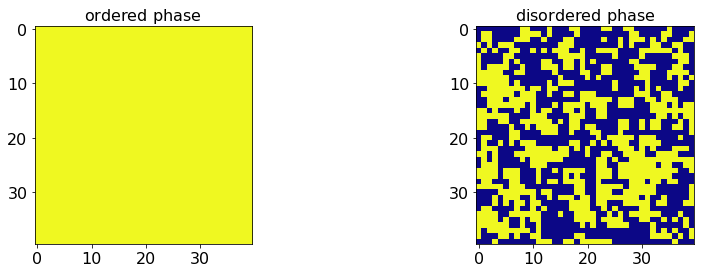

In [10]:
##### prepare training and test data sets
import pickle, os

# path to data directory
path_to_data=os.path.expanduser('~')+'\Documents\GitHub\ml-exercises\Rapport 2\Isingdata\\'

# load data
file_name = "Ising2DFM_reSample_L40_T=All.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
data = pickle.load(open(path_to_data+file_name,'rb')) # pickle reads the file and returns the Python object (1D array, compressed bits)
data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
data=data.astype('int')
data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
labels = pickle.load(open(path_to_data+file_name,'rb')) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

# divide data into ordered, critical and disordered
X_ordered=data[:70000,:]
Y_ordered=labels[:70000]
# we will ignore the critical temperatures
#X_critical=data[70000:100000,:]
#Y_critical=labels[70000:100000]

X_disordered=data[100000:,:]
Y_disordered=labels[100000:]

del data,labels

# define training and test data sets
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

##### plot a few Ising states

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=2)

axarr[0].imshow(X_ordered[20001].reshape(40,40),**cmap_args)
axarr[0].set_title('$\\mathrm{ordered\\ phase}$',fontsize=16)
axarr[0].tick_params(labelsize=16)

im=axarr[1].imshow(X_disordered[50001].reshape(40,40),**cmap_args)
axarr[1].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[1].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()


In [16]:
ising_net = my_NN([1600,800,1], 'relu', 'sigmoid')
ising_net.train(X_train, Y_train, cost_function = 'cross entropy', learning_rate = 0.01, epochs = 50, batch_size = 400, verbose = True)
prediction = np.around(ising_net.predict(X_test))
#print(prediction)
print("Accuracy: %f" % accuracy_score(Y_test, prediction))


Working on epoch 4
Working on epoch 9
Working on epoch 14
Working on epoch 19
Working on epoch 24
Working on epoch 29
Working on epoch 34
Working on epoch 39
Working on epoch 44
Working on epoch 49
Accuracy: 0.786115
